In [1]:
import pandas as pd
import numpy as np
from haversine import haversine, haversine_vector, Unit
import geopandas as gpd
import matplotlib.pyplot as plt
import cma

In [2]:
df = pd.read_csv('data/clean_dataset.csv', converters={'point': pd.eval})

In [3]:
# Filter to only one region to test program.
region = 'Amhara'
gdf_region = gpd.read_file('eth_shape_files/json//eth_admin1v2.json')
gdf_region_shp = gdf_region.loc[gdf_region['ADM1_EN']==region]['geometry'].reset_index(drop=True)
df = df.loc[df['region'] == region]

In [4]:
df['gr_offer'].value_counts()

G.1-8       5145
G.1-4       2197
G. 9-12      185
G. 9-10      182
G. 11-12      17
Name: gr_offer, dtype: int64

In [5]:
# Create subset arrays required as input for enrollment function.
# 1. Primary school enrollment data
# 2. Primary school location data: lat lon point data. 
# 3. Secondary schoool location data: lat lon point data. 
# Secondary school enrollment data. Required for calibration function?

# Data Prep

df_prim = df.loc[ (df['gr_offer'] == 'G.1-8') | (df['gr_offer'] == 'G.5-8')]
df_sec = df.loc[ (df['gr_offer'] == 'G. 9-10') | (df['gr_offer'] == 'G. 9-12')]
df_prim_enroll = df_prim['grade5_8'].reset_index(drop=True).to_numpy()
df_prim_loc = df_prim['point'].reset_index(drop=True).to_numpy()
df_sec_loc = df_sec['point'].reset_index(drop=True).to_numpy()
df_sec_enroll = df_sec['grade9_10'].reset_index(drop=True).to_numpy()
df_prim_loc = np.array([np.array(i) for i in df_prim_loc])
df_sec_loc = np.array([np.array(i) for i in df_sec_loc])

In [6]:
# Function estimate enrollment for schools between 2-5km with enrollment dropping off linearly.
# If the school is <2km, all primary feeder school children expected to attend secondary.
# If >5km no primary feeder school children expected. 

def shape(distance, enrollment):
    min_walk = 2
    max_walk = 5
    if distance < min_walk:
        return enrollment
    elif distance > max_walk:
        return 0
    else:
        return int(abs(enrollment*((distance - max_walk)/min_walk)))

In [7]:
x = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.lon,df.lat))

In [150]:
# Find the box boundary for the region
bounds = gdf_region_shp.bounds
lat_bounds = bounds[['miny','maxy']].to_numpy()[0]
lon_bounds = bounds[['minx','maxx']].to_numpy()[0]
bounds = np.array([lat_bounds, lon_bounds])

In [151]:
# lat, lon
bounds

array([[ 8.71481253, 13.76296565],
       [35.26108445, 40.21243796]])

In [10]:
bounds2 = np.repeat(bounds[None,:],5, axis=0)

In [11]:
bounds2

array([[[ 8.71481253, 13.76296565],
        [35.26108445, 40.21243796]],

       [[ 8.71481253, 13.76296565],
        [35.26108445, 40.21243796]],

       [[ 8.71481253, 13.76296565],
        [35.26108445, 40.21243796]],

       [[ 8.71481253, 13.76296565],
        [35.26108445, 40.21243796]],

       [[ 8.71481253, 13.76296565],
        [35.26108445, 40.21243796]]])

In [12]:
# There are 4 years of upper primary, but two years of lower secondary
# It is assumed that half the population in upper primary will attend secondary.
# This is roughly 52% of the current enrollment in secondary?

# NEED TO DISCUSS. 
df_sec_enroll.sum() / (df_prim_enroll.sum() / 2)

0.51852960949575

In [13]:
np.argmin(df_prim_enroll, axis=0)

3203

In [14]:
df_prim_enroll[0]

51

In [15]:
sum(df_prim_enroll)//2

838185

In [16]:
sum(df_sec_enroll)

434624

In [17]:
## Estimate the Proportion of secondary based on primary enrollment.
enrollment_proportion = round(sum(df_sec_enroll)/ sum(df_prim_enroll//2),2) # regional average
enrollment_proportion = .28

#### This is a problem!


# if already feeder school, then keep secondary, if new school make estimate. 

In [18]:
# Loop through each primary location and identify the minimium distance
# Calculate expected enrollment based on 

# Also want to keep track of expected enrollment per feeder school?

expected_enrollment = 0
for i in range(0, len(df_prim_loc)):
    distance = np.min(haversine_vector(df_prim_loc[i], df_sec_loc, Unit.KILOMETERS, comb=True)) # min distance in km
    s_index = np.argmin(haversine_vector(df_prim_loc[i], df_sec_loc, Unit.KILOMETERS, comb=True)) # index of min secondary
#     print(distance, s_index, i)
#     sec_enrollment = df_sec_enroll[s_index]
#     print(sec_enrollment)
#     enrollment = int(df_prim_enroll[i]*enrollment_proportion)
#     expected_enrollment += enrollment

    enrollment = int(df_prim_enroll[i] *(enrollment_proportion))
#     enrollment2 = int(df_prim_enroll[i]//2) # assume only two years will attend and apply that to shape. 
    expected_enrollment += enrollment
#     expected_enrollment += shape(distance, enrollment) # shape based on distance.

print(expected_enrollment)

466913


In [19]:
sum(df_sec_enroll) 

434624

In [20]:
sum(df_sec_enroll) / expected_enrollment # 4.5% off. 

0.9308457892583843

In [21]:
def check_region(vec):
    # lat = y, x=lon
    vec = gpd.points_from_xy(vec[:, 1], vec[:, 0])
    return vec.within(gdf_region_shp[0]).all()

In [29]:

def expected_enrollment(prim_loc, prim_enroll, x, sec_loc):
    
    # to include: penalise if not in region. 
    
    # for each primary location, identify it's closest secondary location. 
    # if closest, then estimate expected enrollment
    # Run shape function on expected enrollment and distance
    if check_region(x):
        x = np.append(df_sec_loc, x)
        expected_enrollment = 0
        for i in range(0, len(prim_loc)): 
            distance = np.min(haversine_vector(prim_loc[i], x, Unit.KILOMETERS, comb=True)) # min distance in km # lat,lon
#             index = np.argmin(haversine_vector(df_prim_loc[i], df_sec_loc, Unit.KILOMETERS, comb=True)) # index of min secondary 
            enrollment = int(prim_enroll[i] *(enrollment_proportion))
            expected_enrollment += shape(distance, enrollment) # shape based on distance.
        
        return expected_enrollment
    else:
        return 0

#  or if one proposed school has enrollment of zero???
# better to add enrollment for each of the proposed schools?

In [30]:
# test_fn = expected_enrollment(df_prim_loc, df_prim_enroll, df_sec_loc, df_sec_enroll)
# test_fn

In [298]:
# The Objective Function for Random Search and CMA.
proposed_schools = 1
def f(x):
    """ The objective function which takes as input a 1d array. Every two elements represent the lat/lon of a point
    in a given area. A locations variable is created which splits the points into pairs. The total_travel_time function
    is then run on this (5,2) list to return the total travel time for the 5 estimated supermarkets.
    """
    locations = np.array(np.array_split(x, proposed_schools))
    #locations need to be only the 5 new schools. 
    # expected enrollment function then:
    # 1. adds new locations to current locations.
    # 2. checks the total new expected enrollment.
    test_case = expected_enrollment(df_prim_loc, df_prim_enroll, locations, df_sec)
    return test_case*-1

In [400]:
# Create starting points within regional box boundaries.
sp1 = np.random.uniform(low=lat_bounds[0], high=lat_bounds[1], size=5)
sp2 = np.random.uniform(low=lon_bounds[0], high=lon_bounds[1], size=5)
sp = np.vstack((sp1, sp2)).T.flatten()
sp
# sp = np.append(df_sec_loc, sp).flatten() # add to the end of the current secondary locations

array([12.33591377, 36.81789671, 10.07992655, 38.7510846 , 10.39182419,
       35.43886946, 10.86321519, 36.94447795, 13.49494857, 39.9106684 ])

In [401]:
# # boundy = [[lat_bounds[0][0],lat_bounds[0][1]],[lon_bounds[0][0], lon_bounds[0][1]]]
# boundy = [min(min(lat_bounds[0]), min(lon_bounds[0])),max(max(lat_bounds[0]), max(lon_bounds[0]))]
# boundy

In [402]:
tt = np.repeat(bounds[0:1,],proposed_schools, axis=0).flatten()
bb = np.repeat(bounds[1:,],proposed_schools, axis=0).flatten()
boundsx = [tt,bb]

In [403]:
boundsx[1:2]

[array([35.26108445, 40.21243796])]

In [404]:
boundsxx1 = np.repeat(boundsx[0:1],5, axis=0).flatten()
boundsxx2 = np.repeat(boundsx[1:2],5, axis=0).flatten()
boundsxx = [boundsxx1, boundsxx2]
boundsxx

[array([ 8.71481253, 13.76296565,  8.71481253, 13.76296565,  8.71481253,
        13.76296565,  8.71481253, 13.76296565,  8.71481253, 13.76296565]),
 array([35.26108445, 40.21243796, 35.26108445, 40.21243796, 35.26108445,
        40.21243796, 35.26108445, 40.21243796, 35.26108445, 40.21243796])]

In [421]:
boundsxx11 = np.repeat(boundsx[0],5, axis=0).flatten()
boundsxx22 = np.repeat(boundsx[1],5, axis=0).flatten()
boundsxxR = [boundsxx11, boundsxx22]
boundsxxR

[array([ 8.71481253,  8.71481253,  8.71481253,  8.71481253,  8.71481253,
        13.76296565, 13.76296565, 13.76296565, 13.76296565, 13.76296565]),
 array([35.26108445, 35.26108445, 35.26108445, 35.26108445, 35.26108445,
        40.21243796, 40.21243796, 40.21243796, 40.21243796, 40.21243796])]

In [406]:
len(boundsxx)

2

In [423]:
maxits=  10000
es = cma.CMAEvolutionStrategy(sp, sigma0=.8, inopts={'bounds': boundsxx,'seed':12345})
es.optimize(f, iterations=maxits / es.popsize, min_iterations=10)

(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 10 (seed=12345, Tue Jun 21 10:45:15 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     10 -3.070000000000000e+02 1.0e+00 7.56e-01  7e-01  8e-01 0:02.5
    2     20 -3.070000000000000e+02 1.2e+00 7.24e-01  7e-01  7e-01 0:04.3
    3     30 -3.070000000000000e+02 1.2e+00 7.08e-01  7e-01  7e-01 0:06.9
    4     40 -3.070000000000000e+02 1.2e+00 7.46e-01  7e-01  8e-01 0:09.3
    5     50 -3.070000000000000e+02 1.3e+00 7.31e-01  7e-01  8e-01 0:11.9
    6     60 -3.070000000000000e+02 1.3e+00 6.91e-01  7e-01  7e-01 0:14.0
    7     70 -3.070000000000000e+02 1.4e+00 6.66e-01  6e-01  7e-01 0:16.5
    8     80 -3.070000000000000e+02 1.4e+00 6.18e-01  6e-01  6e-01 0:19.2
    9     90 -3.070000000000000e+02 1.4e+00 6.22e-01  6e-01  6e-01 0:21.7
   10    100 -3.070000000000000e+02 1.4e+00 6.05e-01  5e-01  6e-01 0:24.4


In [424]:
es.result[1]

-307

In [425]:
bounds

array([[ 8.71481253, 13.76296565],
       [35.26108445, 40.21243796]])

In [426]:
es.result[0]

array([12.17214764, 37.20105329,  9.66437142, 38.35270108, 11.9644801 ,
       36.55362199, 10.93754372, 37.16988276, 14.11019123, 40.17163418])

In [428]:
vec = np.array(np.array_split(es.result[0],5))
vec = gpd.points_from_xy(vec[:, 1], vec[:, 0])
vec.within(gdf_region_shp[0])

array([ True, False,  True,  True, False])

In [434]:
best_solution = np.array(np.array_split(es.result[0], 5))

In [435]:
# best_solution_found = np.stack(np.array_split(es.result[0], (len(df_sec_loc) + proposed_schools),axis=0))
# best_solution = np.array_split(np.array(es.result[0]), (len(df_sec_loc) + proposed_schools))
# best_solution = np.array([np.array(i) for i in best_solution])

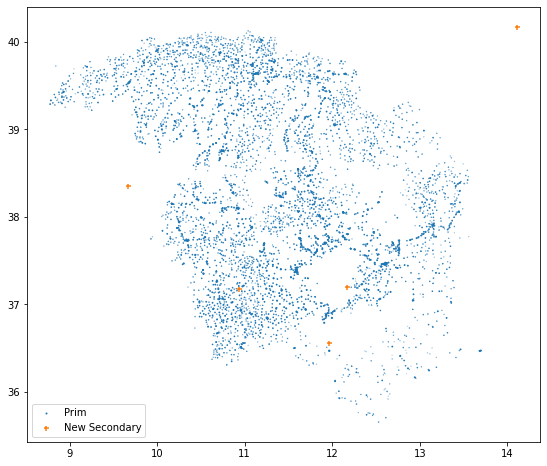

In [436]:
plt.figure(figsize=(10, 8))
plt.scatter(df_prim_loc[:, 0], df_prim_loc[:, 1], s=df_prim_enroll/1000, label="Prim") # s gives size
# plt.scatter(df_sec_loc[:, 0], df_sec_loc[:, 1], s = 10, marker="*", label="Secondary") # stars for supermarkets
plt.scatter(best_solution[:, 0], best_solution[:, 1], s = 25, marker="+", label="New Secondary") # stars for supermarkets
plt.gca().set_aspect('equal')
plt.legend()
plt.show()


In [432]:
w = np.array([0,1])
ww = np.array([[0,1],[0,1]])
ww.shape

(2, 2)

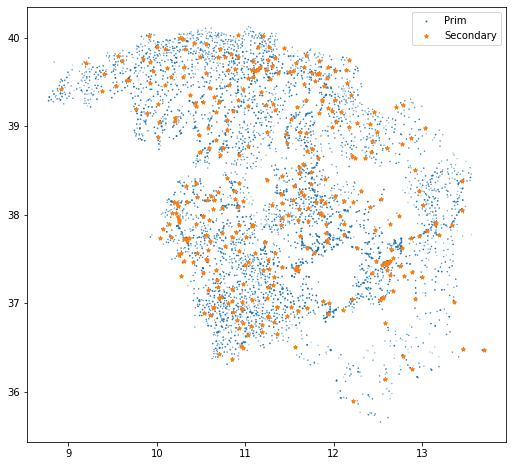

In [433]:
plt.figure(figsize=(10, 8))
plt.scatter(df_prim_loc[:, 0], df_prim_loc[:, 1], s=df_prim_enroll/1000, label="Prim") # s gives size
plt.scatter(df_sec_loc[:, 0], df_sec_loc[:, 1], s = 15, marker="*", label="Secondary") # stars for supermarkets
plt.gca().set_aspect('equal')
plt.legend()
plt.show()
